In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


In [14]:
# Load processed traffic data (temporal features pre-generated in CSV)
import os

data_path = 'data/processed/traffic_data_processed.csv'
df = pd.read_csv(data_path, parse_dates=['start_time'])

# Use only first 30 days for faster iteration
df = df.head(30 * 24 * 12)  # 30 days of 5-min intervals

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nDate range: {df['start_time'].min()} to {df['start_time'].max()}")
print(f"Total days: {(df['start_time'].max() - df['start_time'].min()).days}")

# Features for model: cpu, memory + temporal encodings
feature_cols = ['cpu', 'memory', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_weekend']
print(f"\nFeature columns for model: {feature_cols}")

# Use RobustScaler - robust to outliers (spikes)
scaler = RobustScaler()
features_to_scale = df[['cpu', 'memory']].values
scaler.fit(features_to_scale)
scaled_cpu_mem = scaler.transform(features_to_scale)

print(f"\nRobustScaler statistics:")
print(f"  Center (median): cpu={scaler.center_[0]:.6f}, memory={scaler.center_[1]:.6f}")
print(f"  Scale (IQR): cpu={scaler.scale_[0]:.6f}, memory={scaler.scale_[1]:.6f}")

# Combine scaled cpu/memory with temporal features
features_normalized = np.column_stack([
    scaled_cpu_mem,
    df[['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_weekend']].values
])

print(f"\nNormalized features shape: {features_normalized.shape}")
print(f"\nScaled cpu/memory range:")
print(f"  CPU: [{scaled_cpu_mem[:, 0].min():.2f}, {scaled_cpu_mem[:, 0].max():.2f}]")
print(f"  Memory: [{scaled_cpu_mem[:, 1].min():.2f}, {scaled_cpu_mem[:, 1].max():.2f}]")
print(f"\nOriginal data statistics:")
print(df[['cpu', 'memory']].describe())

Dataset shape: (8640, 10)
Columns: ['start_time', 'cpu', 'memory', 'hour', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

Date range: 2019-04-30 23:55:00 to 2019-05-30 23:50:00
Total days: 29

Feature columns for model: ['cpu', 'memory', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_weekend']

RobustScaler statistics:
  Center (median): cpu=0.014793, memory=0.002927
  Scale (IQR): cpu=0.030637, memory=0.006041

Normalized features shape: (8640, 7)

Scaled cpu/memory range:
  CPU: [-0.47, 8.45]
  Memory: [-0.47, 8.95]

Original data statistics:
               cpu       memory
count  8640.000000  8640.000000
mean      0.023432     0.004689
std       0.024116     0.004873
min       0.000381     0.000071
25%       0.004792     0.000950
50%       0.014793     0.002927
75%       0.035429     0.006990
max       0.273661     0.056972


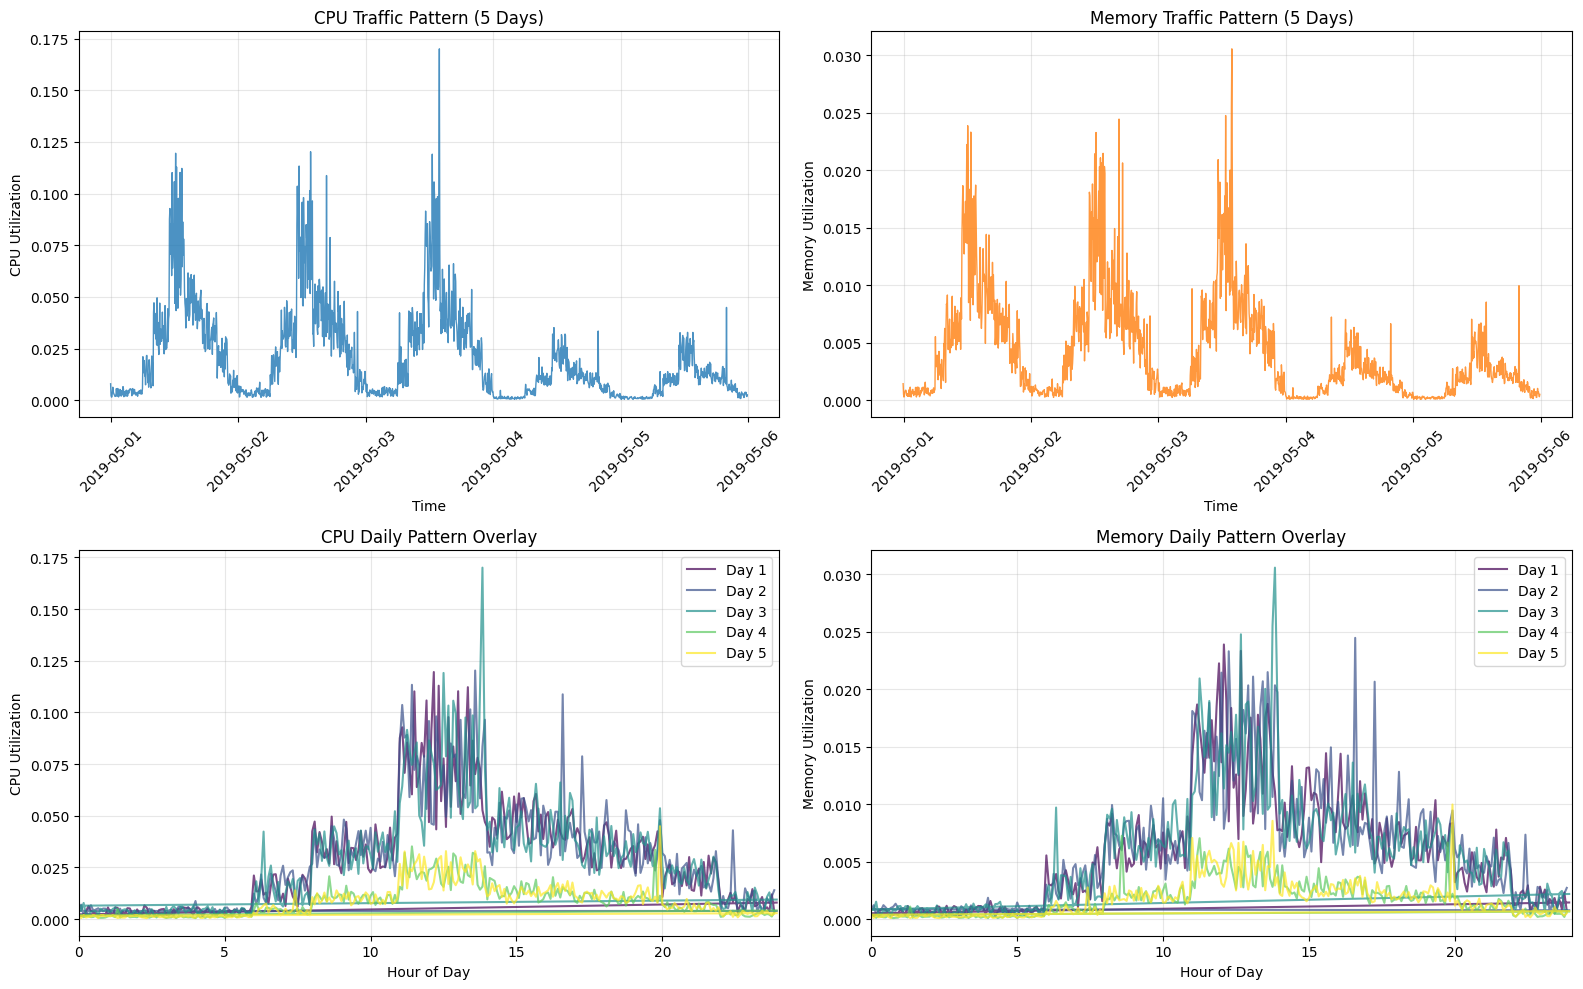

Showing 1440 samples (5 days)
Date range shown: 2019-04-30 23:55:00 to 2019-05-05 23:50:00


In [ ]:
# Visualize traffic patterns for 5 days
samples_per_day = 24 * 12
n_days = 5
n_samples = samples_per_day * n_days

df_5days = df.head(n_samples).copy()
df_5days['day'] = (df_5days['start_time'] - df_5days['start_time'].min()).dt.days
df_5days['hour'] = df_5days['start_time'].dt.hour + df_5days['start_time'].dt.minute / 60

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# CPU over 5 days - continuous timeline
axes[0, 0].plot(df_5days['start_time'], df_5days['cpu'], linewidth=1, alpha=0.8, color='tab:blue')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('CPU Utilization')
axes[0, 0].set_title(f'CPU Traffic Pattern ({n_days} Days)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Memory over 5 days - continuous timeline
axes[0, 1].plot(df_5days['start_time'], df_5days['memory'], linewidth=1, alpha=0.8, color='tab:orange')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Memory Utilization')
axes[0, 1].set_title(f'Memory Traffic Pattern ({n_days} Days)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

colors = plt.cm.viridis(np.linspace(0, 1, n_days))
for day in range(n_days):
    day_data = df_5days[df_5days['day'] == day]
    axes[1, 0].plot(day_data['hour'], day_data['cpu'], linewidth=1.5, alpha=0.7, 
                    color=colors[day], label=f'Day {day+1}')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('CPU Utilization')
axes[1, 0].set_title('CPU Daily Pattern Overlay')
axes[1, 0].legend(loc='upper right')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(0, 24)

for day in range(n_days):
    day_data = df_5days[df_5days['day'] == day]
    axes[1, 1].plot(day_data['hour'], day_data['memory'], linewidth=1.5, alpha=0.7,
                    color=colors[day], label=f'Day {day+1}')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Memory Utilization')
axes[1, 1].set_title('Memory Daily Pattern Overlay')
axes[1, 1].legend(loc='upper right')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, 24)

plt.tight_layout()
plt.show()

print(f"Showing {n_samples} samples ({n_days} days)")
print(f"Date range shown: {df_5days['start_time'].min()} to {df_5days['start_time'].max()}")

In [ ]:
# Shorter window since patterns are clear and recent history matters most
def create_sequences_overlapping(data, seq_length=6, stride=1):
    X, y = [], []
    for i in range(0, len(data) - seq_length, stride):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, :2])
    return np.array(X), np.array(y)

SEQ_LENGTH = 6 # playing around with 30 vs 60
STRIDE = 1
N_FEATURES = 7

X, y = create_sequences_overlapping(features_normalized, seq_length=SEQ_LENGTH, stride=STRIDE)

print(f"Input sequences shape: {X.shape}")
print(f"Target values shape: {y.shape}")
print(f"\nSequence length: {SEQ_LENGTH} timesteps ({SEQ_LENGTH * 5} minutes)")
print(f"Features: {N_FEATURES}")

Input sequences shape: (8634, 6, 7)
Target values shape: (8634, 2)

Sequence length: 6 timesteps (30 minutes)
Features: 7


In [17]:
# Split data - 80/20
train_size = int(0.8 * len(X))
indices = np.random.permutation(len(X))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

print(f"Train set: {X_train.shape[0]} sequences")
print(f"Test set: {X_test.shape[0]} sequences")

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")

Train set: 6907 sequences
Test set: 1727 sequences
Batch size: 64
Training batches: 108


In [ ]:
class TrafficPredictorV5(nn.Module):
    def __init__(self, input_size=7, hidden_size=128, num_layers=2, dropout=0.2, output_size=2):
        super(TrafficPredictorV5, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.bn = nn.BatchNorm1d(hidden_size)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size + 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        last_input = x[:, -1, :2]
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        last_hidden = self.bn(last_hidden)
        combined = torch.cat([last_hidden, last_input], dim=1)
        out = self.fc(combined)
        return out

model = TrafficPredictorV5(input_size=N_FEATURES).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model: TrafficPredictorV5")
print(f"Total parameters: {total_params:,}")
print(model)

test_input = torch.randn(BATCH_SIZE, SEQ_LENGTH, N_FEATURES).to(device)
test_output = model(test_input)
print(f"\nTest: input {test_input.shape} -> output {test_output.shape}")

Model: TrafficPredictorV5
Total parameters: 213,026
TrafficPredictorV5(
  (lstm): LSTM(7, 128, num_layers=2, batch_first=True, dropout=0.2)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=130, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=2, bias=True)
  )
)

Test: input torch.Size([64, 6, 7]) -> output torch.Size([64, 2])


In [ ]:
# Training setup with Huber loss (less sensitive to outliers than MSE)
criterion = nn.HuberLoss(delta=1.0)

LEARNING_RATE = 0.002
WEIGHT_DECAY = 1e-5  # reg

optimizer = optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Cosine annealing for smooth LR decay
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=20,
    T_mult=2
)

NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 25

print("Training Configuration:")
print(f"  Loss: HuberLoss (delta=1.0) - robust to outliers")
print(f"  Optimizer: AdamW")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Scheduler: CosineAnnealingWarmRestarts")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Early stopping patience: {EARLY_STOP_PATIENCE}")

Training Configuration:
  Loss: HuberLoss (delta=1.0) - robust to outliers
  Optimizer: AdamW
  Learning rate: 0.002
  Weight decay: 1e-05
  Scheduler: CosineAnnealingWarmRestarts
  Epochs: 100
  Early stopping patience: 25


In [20]:
# Training loop
train_losses = []
test_losses = []
learning_rates = []
best_test_loss = float('inf')
patience_counter = 0
best_model_state = None

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    scheduler.step()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Eval
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train: {avg_train_loss:.6f}, Test: {avg_test_loss:.6f}, LR: {current_lr:.6f}")
    
    # Early stopping
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print(f"\n{'='*50}")
print(f"Training Complete!")
print(f"Best Test Loss: {best_test_loss:.6f}")
print(f"{'='*50}")

Starting training...

Epoch [1/100] - Train: 0.073958, Test: 0.063237, LR: 0.001988
Epoch [10/100] - Train: 0.054705, Test: 0.060397, LR: 0.001000
Epoch [20/100] - Train: 0.049934, Test: 0.057339, LR: 0.002000
Epoch [30/100] - Train: 0.052723, Test: 0.058536, LR: 0.001707
Epoch [40/100] - Train: 0.048649, Test: 0.060023, LR: 0.001000
Epoch [50/100] - Train: 0.046090, Test: 0.059312, LR: 0.000293
Epoch [60/100] - Train: 0.044646, Test: 0.058394, LR: 0.002000

Early stopping at epoch 67

Training Complete!
Best Test Loss: 0.056233


In [ ]:
# training curves
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training and Test Loss Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log scale loss
axes[1].plot(train_losses, label='Train Loss', linewidth=2)
axes[1].plot(test_losses, label='Test Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss (log scale)')
axes[1].set_title('Training and Test Loss (Log Scale)')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate
axes[2].plot(learning_rates, linewidth=2, color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total epochs trained: {len(train_losses)}")
print(f"Best test loss achieved: {min(test_losses):.6f} at epoch {test_losses.index(min(test_losses))+1}")

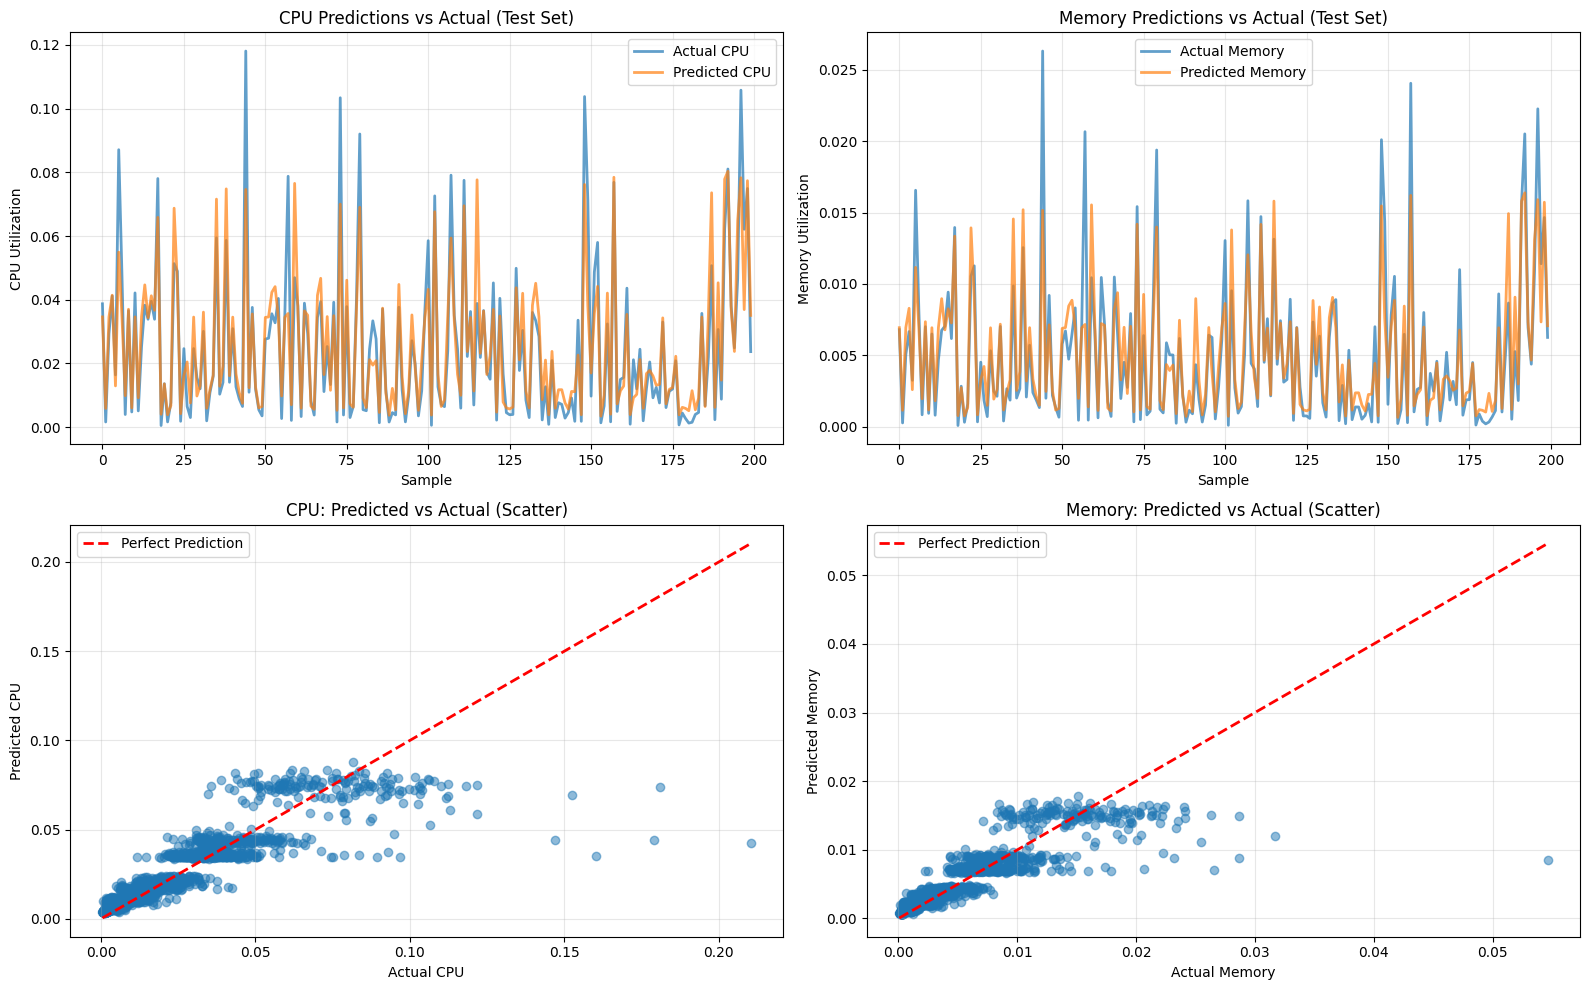

In [ ]:
# predictions
model.eval()

with torch.no_grad():
    y_pred_test = model(X_test_tensor).cpu().numpy()
    y_true_test = y_test_tensor.cpu().numpy()

y_pred_actual = scaler.inverse_transform(y_pred_test)
y_true_actual = scaler.inverse_transform(y_true_test)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# CPU Predictions vs Actual (first 200 samples)
n_samples = min(200, len(y_true_actual))
axes[0, 0].plot(y_true_actual[:n_samples, 0], label='Actual CPU', linewidth=2, alpha=0.7)
axes[0, 0].plot(y_pred_actual[:n_samples, 0], label='Predicted CPU', linewidth=2, alpha=0.7)
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('CPU Utilization')
axes[0, 0].set_title('CPU Predictions vs Actual (Test Set)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Memory Predictions vs Actual (first 200 samples)
axes[0, 1].plot(y_true_actual[:n_samples, 1], label='Actual Memory', linewidth=2, alpha=0.7)
axes[0, 1].plot(y_pred_actual[:n_samples, 1], label='Predicted Memory', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Sample')
axes[0, 1].set_ylabel('Memory Utilization')
axes[0, 1].set_title('Memory Predictions vs Actual (Test Set)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# CPU Scatter Plot
axes[1, 0].scatter(y_true_actual[:, 0], y_pred_actual[:, 0], alpha=0.5)
axes[1, 0].plot([y_true_actual[:, 0].min(), y_true_actual[:, 0].max()], 
                [y_true_actual[:, 0].min(), y_true_actual[:, 0].max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual CPU')
axes[1, 0].set_ylabel('Predicted CPU')
axes[1, 0].set_title('CPU: Predicted vs Actual (Scatter)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Memory Scatter Plot
axes[1, 1].scatter(y_true_actual[:, 1], y_pred_actual[:, 1], alpha=0.5)
axes[1, 1].plot([y_true_actual[:, 1].min(), y_true_actual[:, 1].max()], 
                [y_true_actual[:, 1].min(), y_true_actual[:, 1].max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Memory')
axes[1, 1].set_ylabel('Predicted Memory')
axes[1, 1].set_title('Memory: Predicted vs Actual (Scatter)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

# R^2 scores
r2_cpu = r2_score(y_true_actual[:, 0], y_pred_actual[:, 0])
r2_mem = r2_score(y_true_actual[:, 1], y_pred_actual[:, 1])

# MAE scores
mae_cpu = mean_absolute_error(y_true_actual[:, 0], y_pred_actual[:, 0])
mae_mem = mean_absolute_error(y_true_actual[:, 1], y_pred_actual[:, 1])

print("Model Performance Metrics:")
print(f"\nR² Scores:")
print(f"  CPU: {r2_cpu:.4f}")
print(f"  Memory: {r2_mem:.4f}")
print(f"\nMAE Scores:")
print(f"  CPU: {mae_cpu:.6f}")
print(f"  Memory: {mae_mem:.6f}")

Model Performance Metrics:

R² Scores:
  CPU: 0.7736
  Memory: 0.7679

MAE Scores:
  CPU: 0.006461
  Memory: 0.001335


In [ ]:
# Export model, scaler, and config for inference
import pickle

ver = 8

os.makedirs('models', exist_ok=True)
model_path = f'models/traffic_predictor_v{ver}.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Save scaler for inference (only for cpu and memory)
scaler_path = f'models/scaler_v{ver}.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to {scaler_path}")

# Save model config
config = {
    'model_version': f'v{ver}',
    'input_size': N_FEATURES,
    'hidden_size': 64,
    'num_layers': 2,
    'dropout': 0.3,
    'output_size': 2,
    'bidirectional': True,
    'attention': True,
    'seq_length': SEQ_LENGTH,
    'stride': STRIDE,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
    'best_test_loss': best_test_loss,
    'r2_cpu': r2_cpu,
    'r2_memory': r2_mem,
    'feature_order': ['cpu', 'memory', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_weekend'],
    'target_order': ['cpu', 'memory']
}

config_path = f'models/config_v{ver}.pkl'
with open(config_path, 'wb') as f:
    pickle.dump(config, f)
print(f"Config saved to {config_path}")

print(f"\nAll artifacts exported to models/ directory")
print(f"\nModel config:")
for k, v in config.items():
    print(f"  {k}: {v}")

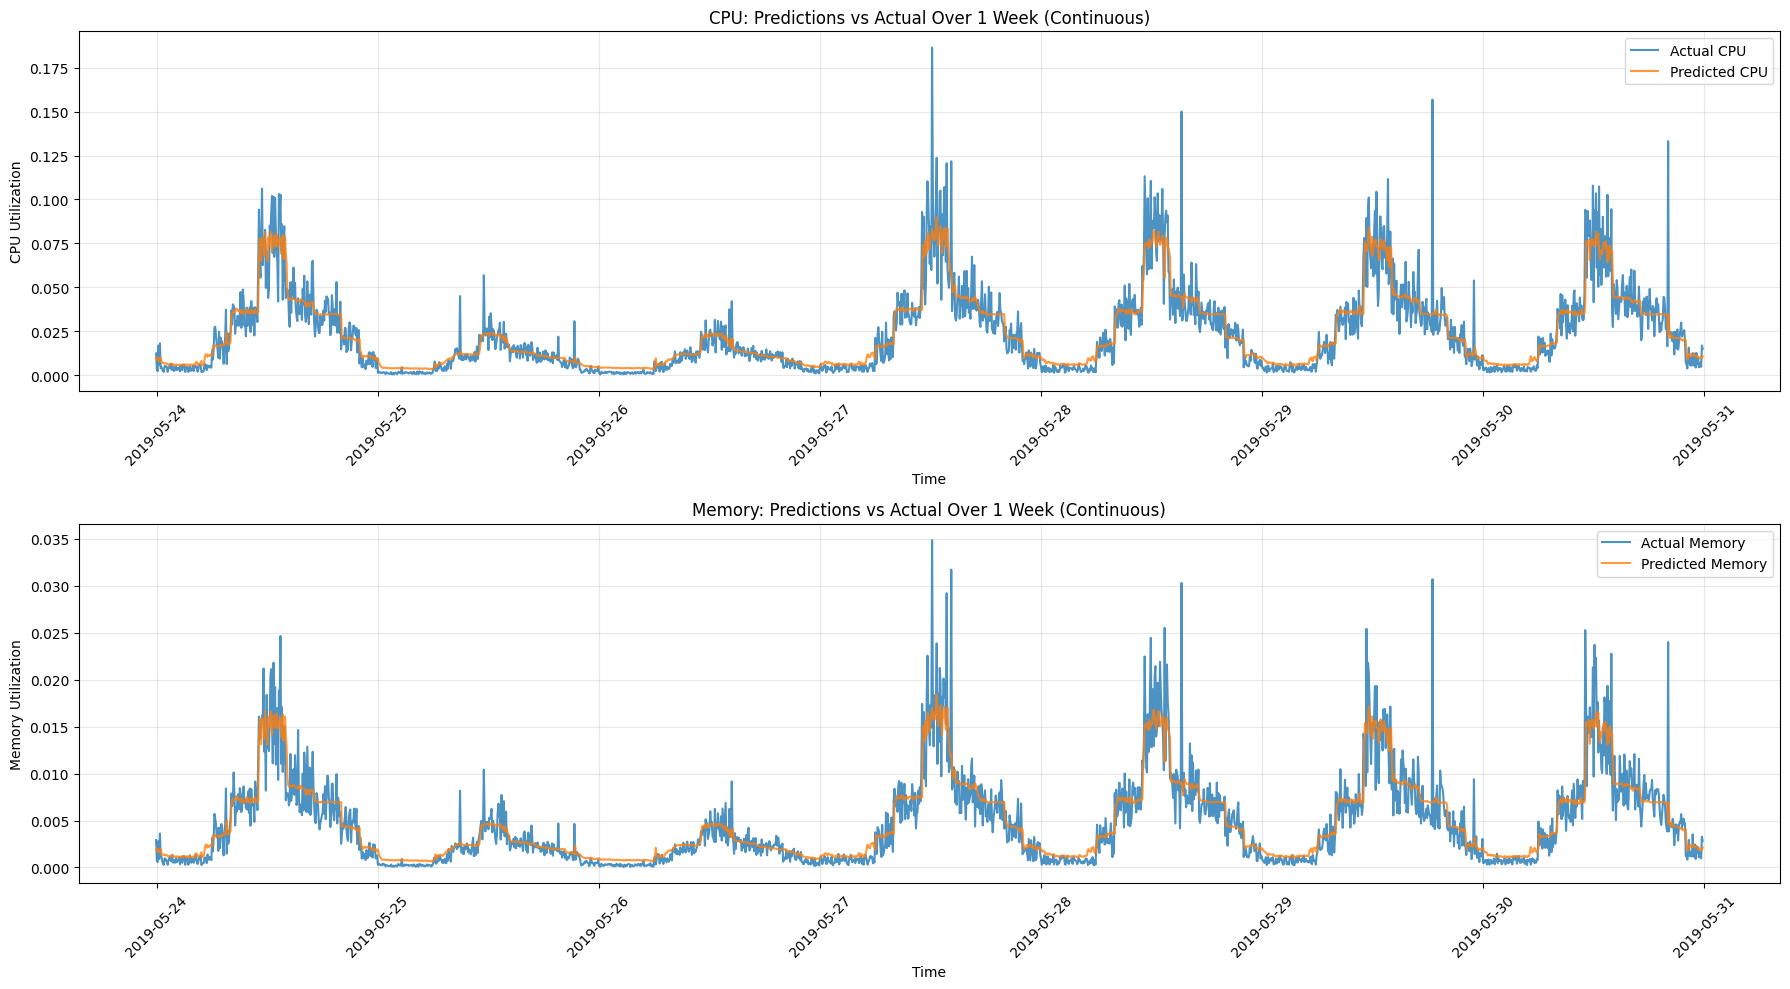


Week-long Prediction Metrics:
  R² CPU: 0.8301
  R² Memory: 0.8217
  MAE CPU: 0.005917
  MAE Memory: 0.001215


In [ ]:
# Week-long prediction visualization

model.eval()
samples_per_day = 24 * 12
week_samples = 7 * samples_per_day

week_features = features_normalized[-week_samples - SEQ_LENGTH:]
week_timestamps = df['start_time'].values[-week_samples:]

week_predictions = []
week_actuals = []

with torch.no_grad():
    for i in range(week_samples):
        seq = week_features[i:i + SEQ_LENGTH]
        seq_tensor = torch.FloatTensor(seq).unsqueeze(0).to(device)
        
        pred = model(seq_tensor).cpu().numpy()[0]
        week_predictions.append(pred)
        
        actual = week_features[i + SEQ_LENGTH, :2]
        week_actuals.append(actual)

week_predictions = np.array(week_predictions)
week_actuals = np.array(week_actuals)

week_pred_actual = scaler.inverse_transform(week_predictions)
week_true_actual = scaler.inverse_transform(week_actuals)

fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# CPU over the week
axes[0].plot(week_timestamps, week_true_actual[:, 0], label='Actual CPU', linewidth=1.5, alpha=0.8)
axes[0].plot(week_timestamps, week_pred_actual[:, 0], label='Predicted CPU', linewidth=1.5, alpha=0.8)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('CPU Utilization')
axes[0].set_title('CPU: Predictions vs Actual Over 1 Week (Continuous)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Memory over the week
axes[1].plot(week_timestamps, week_true_actual[:, 1], label='Actual Memory', linewidth=1.5, alpha=0.8)
axes[1].plot(week_timestamps, week_pred_actual[:, 1], label='Predicted Memory', linewidth=1.5, alpha=0.8)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Memory Utilization')
axes[1].set_title('Memory: Predictions vs Actual Over 1 Week (Continuous)')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate metrics for this week
from sklearn.metrics import r2_score, mean_absolute_error
r2_cpu_week = r2_score(week_true_actual[:, 0], week_pred_actual[:, 0])
r2_mem_week = r2_score(week_true_actual[:, 1], week_pred_actual[:, 1])
mae_cpu_week = mean_absolute_error(week_true_actual[:, 0], week_pred_actual[:, 0])
mae_mem_week = mean_absolute_error(week_true_actual[:, 1], week_pred_actual[:, 1])

print(f"\nWeek-long Prediction Metrics:")
print(f"  R² CPU: {r2_cpu_week:.4f}")
print(f"  R² Memory: {r2_mem_week:.4f}")
print(f"  MAE CPU: {mae_cpu_week:.6f}")
print(f"  MAE Memory: {mae_mem_week:.6f}")